In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

## Rolling Mean-Squared Error

Az RMSE-t a következőképpen számoltam:

$$RMSE = \frac{1}{12} \sum_{i=1 + \tau}^{12 + \tau} (y_{actual} - y_{pred})^2$$

ahol $\tau$ jelöli a léptetéseket. A számítása során 12 hónap adataira számolom a mutatót, aminek során először is kiszámolom a különbségeket asset-enként, azokat négyzetre emelem és végül veszem az átlagukat, úgy hogy a NaN értékeket kiejtem.

In [2]:
daily_act = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/daily_vola.csv')
daily_act.set_index(daily_act.iloc[:, 0], inplace = True)
daily_act = daily_act.iloc[:-1, 1:]
daily_act.pop('AMCR')

two_daily_act = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/two_daily_vola.csv')
two_daily_act.set_index(two_daily_act.iloc[:, 0], inplace = True)
two_daily_act = two_daily_act.iloc[:-1, 1:]
two_daily_act.pop('AMCR')

weekly_act = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/weekly_vola.csv')
weekly_act.set_index(weekly_act.iloc[:, 0], inplace = True)
weekly_act = weekly_act.iloc[:-1, 1:]
weekly_act.pop('AMCR')

two_weekly_act = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/two_weekly_vola.csv')
two_weekly_act.set_index(two_weekly_act.iloc[:, 0], inplace = True)
two_weekly_act = two_weekly_act.iloc[:-1, 1:]
two_weekly_act.pop('AMCR')

monthly_act = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/monthly_vola.csv')
monthly_act.set_index(monthly_act.iloc[:, 0], inplace = True)
monthly_act = monthly_act.iloc[:-1, 1:]
monthly_act.pop('AMCR')

Unnamed: 0
2005-01-01          NaN
2005-02-01          NaN
2005-03-01          NaN
2005-04-01          NaN
2005-05-01          NaN
                ...    
2020-06-01    40.139310
2020-07-01     7.751707
2020-08-01     8.723799
2020-09-01    14.385626
2020-10-01     7.166337
Name: AMCR, Length: 190, dtype: float64

In [3]:
gm_norm = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/Panel_GARCH_MIDAS/Concated/forecast_norm.csv')
gm_norm.set_index(pd.to_datetime(gm_norm.iloc[:, 0]), inplace = True)
gm_norm = gm_norm.iloc[:, 1:]
gm_norm_avg = np.nanmean(gm_norm.values, axis = 1)

gm_stud = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/Panel_GARCH_MIDAS/Concated/forecast_stud.csv')
gm_stud.set_index(pd.to_datetime(gm_stud.iloc[:, 0]), inplace = True)
gm_stud = gm_stud.iloc[:, 1:]
gm_stud_avg = np.nanmean(gm_stud.values, axis = 1)

pred1 = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/Panel_GARCH/forecast_norm_dist.csv')
pred1 = pred1.T
pred1.columns = pred1.iloc[0, :].values
pred1 = pred1.iloc[1:, :]
pred1.pop('AMCR')
pred1 = pred1.astype(float)
pred1_avg = np.nanmean(pred1.values, axis = 1)

pred2 = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/Panel_GARCH/forecast_t_dist.csv')
pred2 = pred2.T
pred2.columns = pred2.iloc[0, :].values
pred2 = pred2.iloc[1:, :]
pred2.pop('AMCR')
pred2 = pred2.astype(float)
pred2_avg = np.nanmean(pred2.values, axis = 1)

ewma = pd.read_csv('C:/Users/peter/Desktop/volatility-forecasting/results/Panel_EWMA/forecast.csv')
ewma.set_index(ewma.iloc[:, 0], inplace = True)
ewma = ewma.iloc[:, 1:]
ewma.columns = pd.to_datetime(ewma.columns)
for i in range(ewma.shape[1]):
    ewma.iloc[:, i][ewma.iloc[:, i] == 1.00] = np.nan
ewma = ewma.T
ewma_avg = np.nanmean(ewma.values, axis = 1)

In [16]:
def calc_rmse(actual):
    gm_norm_rmse = []
    gm_stud_rmse = []
    g_norm_rmse = []
    g_stud_rmse = []
    ewma_rmse = []
    
    for i in range(190):
        gnmse = np.nanmean((actual.iloc[i, :].values - gm_norm.iloc[i, :].values) ** 2)
        gm_norm_rmse.append(gnmse)
        gsmse = np.nanmean((actual.iloc[i, :].values - gm_stud.iloc[i, :].values) ** 2)
        gm_stud_rmse.append(gsmse)
        garch_norm_mse = np.nanmean((actual.iloc[i, :].values - pred1.iloc[i, :].values) ** 2)
        g_norm_rmse.append(garch_norm_mse)
        garch_stud_mse = np.nanmean((actual.iloc[i, :].values - pred2.iloc[i, :].values) ** 2)
        g_stud_rmse.append(garch_stud_mse)
        emse = np.nanmean((actual.iloc[i, :].values - ewma.iloc[i, :].values) ** 2)
        ewma_rmse.append(emse)
    df = pd.DataFrame(data = {'GARCH_norm': g_norm_rmse, 'GARCH_stud': g_stud_rmse, 'GARCH_MIDAS_norm': gm_norm_rmse, 'GARCH_MIDAS_stud': gm_stud_rmse, 'EWMA': ewma_rmse}, index = pd.to_datetime(daily_act.index))
    
    return df

In [17]:
daily_rmse = calc_rmse(daily_act).apply(np.sqrt)
two_daily_rmse = calc_rmse(two_daily_act).apply(np.sqrt)
weekly_rmse = calc_rmse(weekly_act).apply(np.sqrt)
two_weekly_rmse = calc_rmse(two_weekly_act).apply(np.sqrt)
monthly_rmse = calc_rmse(monthly_act).apply(np.sqrt)

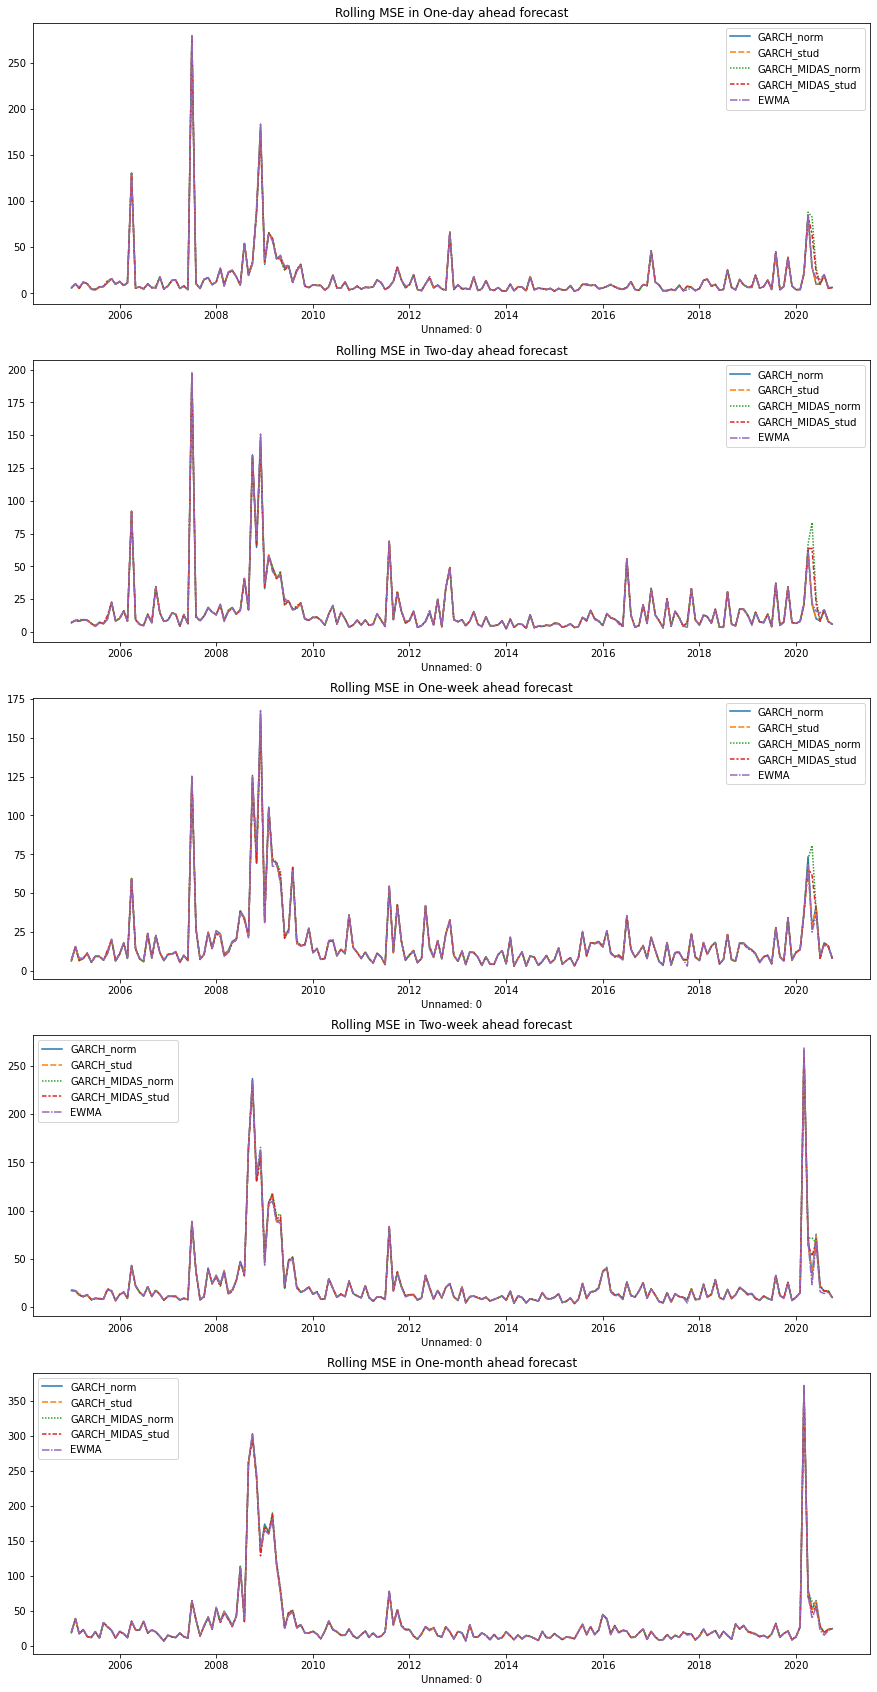

In [18]:
fig, ax = plt.subplots(5, 1, figsize = (15,30))

sns.lineplot(data = daily_rmse, ax = ax[0])
ax[0].legend(loc = 'best')
ax[0].set_title('Rolling MSE in One-day ahead forecast')

sns.lineplot(data = two_daily_rmse, ax = ax[1])
ax[1].legend(loc = 'best')
ax[1].set_title('Rolling MSE in Two-day ahead forecast')

sns.lineplot(data = weekly_rmse, ax = ax[2])
ax[2].legend(loc = 'best')
ax[2].set_title('Rolling MSE in One-week ahead forecast')

sns.lineplot(data = two_weekly_rmse, ax = ax[3])
ax[3].legend(loc = 'best')
ax[3].set_title('Rolling MSE in Two-week ahead forecast')

sns.lineplot(data = monthly_rmse, ax = ax[4])
ax[4].legend(loc = 'best')
ax[4].set_title('Rolling MSE in One-month ahead forecast')

plt.show()

In [23]:
daily_rmse.mean()

GARCH_norm          15.135194
GARCH_stud          15.138915
GARCH_MIDAS_norm    15.524321
GARCH_MIDAS_stud    15.366298
EWMA                15.173440
dtype: float64

In [24]:
two_daily_rmse.mean()

GARCH_norm          15.963789
GARCH_stud          15.956514
GARCH_MIDAS_norm    16.397448
GARCH_MIDAS_stud    16.218410
EWMA                16.013639
dtype: float64

In [25]:
weekly_rmse.mean()

GARCH_norm          18.268116
GARCH_stud          18.203876
GARCH_MIDAS_norm    18.549485
GARCH_MIDAS_stud    18.340503
EWMA                18.194543
dtype: float64

In [26]:
two_weekly_rmse.mean()

GARCH_norm          23.216528
GARCH_stud          23.121547
GARCH_MIDAS_norm    23.404471
GARCH_MIDAS_stud    23.183839
EWMA                22.997446
dtype: float64

In [27]:
monthly_rmse.mean()

GARCH_norm          31.101890
GARCH_stud          31.007633
GARCH_MIDAS_norm    31.157940
GARCH_MIDAS_stud    30.952451
EWMA                30.875841
dtype: float64

In [28]:
df_intercept_d = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA'], index = daily_act.columns)
df_coef_d = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA'], index = daily_act.columns)
df_score_d = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA'], index = daily_act.columns)

df_intercept_td = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA'], index = daily_act.columns)
df_coef_td = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA'], index = daily_act.columns)
df_score_td = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA'], index = daily_act.columns)

df_intercept_w = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA'], index = daily_act.columns)
df_coef_w = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA'], index = daily_act.columns)
df_score_w = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA'], index = daily_act.columns)

df_intercept_tw = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA'], index = daily_act.columns)
df_coef_tw = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA'], index = daily_act.columns)
df_score_tw = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA'], index = daily_act.columns)

df_intercept_m = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA'], index = daily_act.columns)
df_coef_m = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA'], index = daily_act.columns)
df_score_m = pd.DataFrame(columns = ['GARCH_norm','GARCH_stud','GARCH_MIDAS_norm','GARCH_MIDAS_stud','EWMA'], index = daily_act.columns)

In [31]:
dd = {'0': pred1, '1': pred2, '2': gm_norm, '3':gm_stud, '4': ewma}

model = LinearRegression()
for i in range(daily_act.shape[1]):
    for tag in dd:
        nan = dd[tag].iloc[:, i].isna().sum()
        X = dd[tag].iloc[nan:, i].values.reshape(-1,1)
        y_d = daily_act.iloc[nan:, i].values
        model.fit(X, y_d)
        df_score_d.iloc[i, int(tag)] = model.score(X, y_d)
        df_intercept_d.iloc[i, int(tag)] = model.intercept_
        df_coef_d.iloc[i, int(tag)] = model.coef_

        y_td = two_daily_act.iloc[nan:, i].values
        model.fit(X, y_td)
        df_score_td.iloc[i, int(tag)] = model.score(X, y_td)
        df_intercept_td.iloc[i, int(tag)] = model.intercept_
        df_coef_td.iloc[i, int(tag)] = model.coef_

        y_w = weekly_act.iloc[nan:, i].values
        model.fit(X, y_w)
        df_score_w.iloc[i, int(tag)] = model.score(X, y_w)
        df_intercept_w.iloc[i, int(tag)] = model.intercept_
        df_coef_w.iloc[i, int(tag)] = model.coef_

        y_tw = two_weekly_act.iloc[nan:, i].values
        model.fit(X, y_tw)
        df_score_tw.iloc[i, int(tag)] = model.score(X, y_tw)
        df_intercept_tw.iloc[i, int(tag)] = model.intercept_
        df_coef_tw.iloc[i, int(tag)] = model.coef_

        y_m = monthly_act.iloc[nan:, i].values
        model.fit(X, y_w)
        df_score_m.iloc[i, int(tag)] = model.score(X, y_m)
        df_intercept_m.iloc[i, int(tag)] = model.intercept_
        df_coef_m.iloc[i, int(tag)] = model.coef_

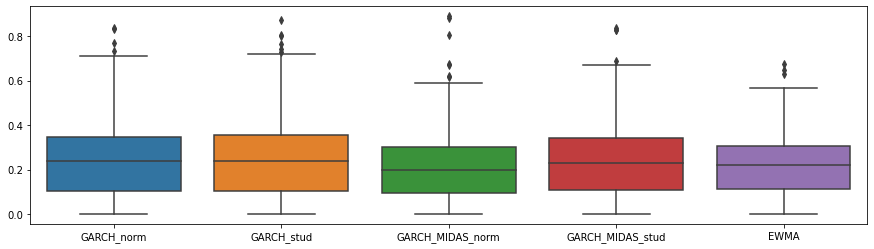

In [36]:
plt.figure(figsize = (15,4))
sns.boxplot(data = df_score_d)
plt.show()

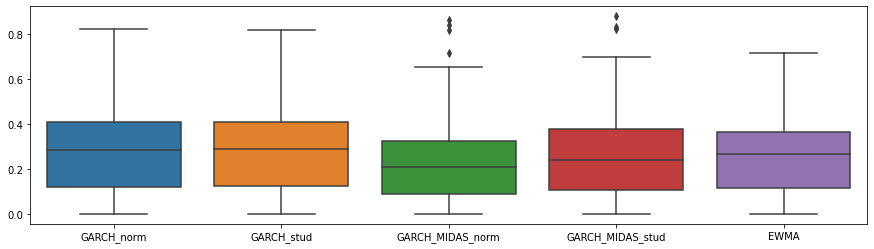

In [38]:
plt.figure(figsize = (15,4))
sns.boxplot(data = df_score_td)
plt.show()

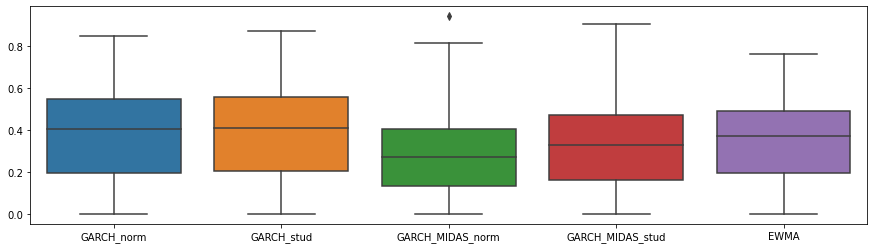

In [39]:
plt.figure(figsize = (15,4))
sns.boxplot(data = df_score_w)
plt.show()

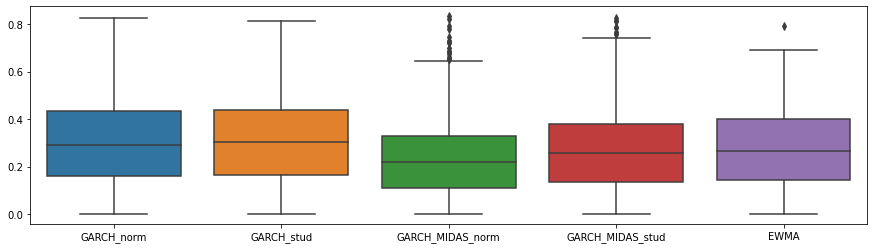

In [40]:
plt.figure(figsize = (15,4))
sns.boxplot(data = df_score_tw)
plt.show()

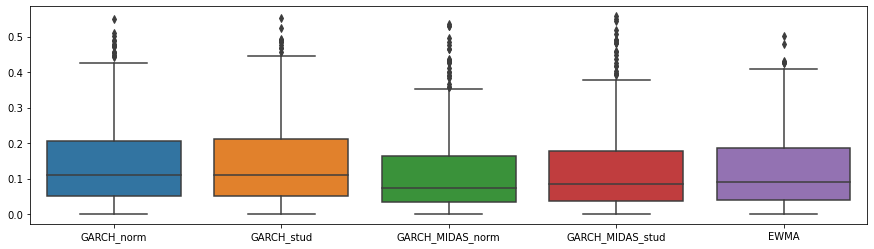

In [43]:
plt.figure(figsize = (15,4))
sns.boxplot(data = df_score_m.abs())
plt.show()